In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.io import loadmat
import numpy as np
import random as rand
import mlmodel
import math
import pickle as pkl
import chart_studio.plotly as py
from importlib import reload
import plotly.graph_objects as go
from functools import reduce
from PIL import Image
import os
import matplotlib.pyplot as plt

import pose_2D as pose2d
import pose_3D as pose3d
import visual as vs

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [118]:
pose2d = reload(pose2d)
pose3d = reload(pose3d)
vs = reload(vs)

## 1- load model

In [ ]:
torch.cuda.is_available()

In [ ]:
#device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.current_device()

In [2]:
net = mlmodel.LinearModel(59, 9, num_stage=3)
net = net.to(device)

In [ ]:
params = torch.load('net-v0_2.pkl')
net.load_state_dict(params)

In [ ]:
def infer(inputs, model):
    with torch.no_grad():
        net = model
        net = net.to(device)
        net.eval()
        inputs = torch.from_numpy(inputs).float().to(device)
        outputs = net(inputs)
        outputs.cpu().detach().numpy()
    return outputs

def find_error(inputs, gt, model):
    pred = infer(inputs, model).cpu().numpy()
    return np.mean(np.linalg.norm(gt-pred, axis = 1))

## 2- Find proportions

convert all images to jpg and scale them down

In [111]:
path = './data/pifpaf/cam_calibration_images/'
max_size = 2*480*640
labels_names=os.listdir(path)
labels_names.sort()
for label in labels_names:
        pose2d.scale_and_convert(path+label, max_size)
        

run pifpaf on some proportion calibation images

In [73]:
! python3 -m openpifpaf.predict ./data/pifpaf/proportions_images/*.jpg  --force-complete-pose -o ./data/pifpaf/proportions_jsons/

/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'openpifpaf.network.nets.Shell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retri

In [119]:
pifpaf = pose2d.load_pifpaf('./data/pifpaf/proportions_jsons/')
pifpaf = [x for x in pifpaf if np.mean(x['confidence'])>0.2]
print('we keep', len(pifpaf), 'pedestrians')

(2, 21)
(2, 21)
(2, 21)
(2, 21)
(2, 21)
(2, 21)
(2, 21)
(2, 21)
(2, 21)
(2, 21)
(2, 21)
(2, 21)
(2, 21)
(2, 21)
(2, 21)
(2, 21)
(2, 21)
(2, 21)
(2, 21)
(2, 21)
(2, 21)
(2, 21)
(2, 21)
(2, 21)
we loaded 24 pedestrians
we keep 17 pedestrians


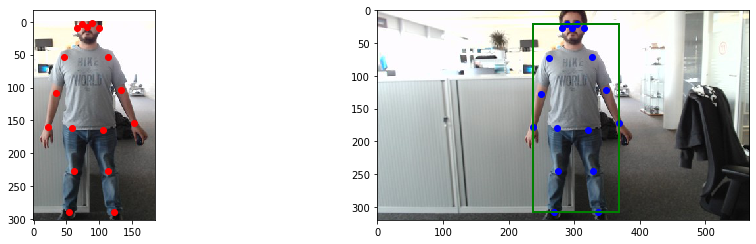

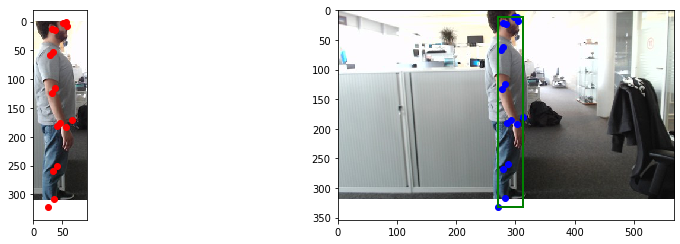

In [120]:
i=15
front_view2 = pifpaf[i]['conv_keypoints']
side_view = pifpaf[i+1]['conv_keypoints']
vs.show_pp_on_image(pifpaf[i],'./data/pifpaf/proportions_images/','.jpg')
vs.show_pp_on_image(pifpaf[i+1],'./data/pifpaf/proportions_images/','.jpg')

In [76]:
body_props_1, face_pos_1 = pose2d.get_proportions(front_view, side_view)

In [80]:
def pixel_to_camera(uv_tensor, kk, z_met):
    """
    Convert a tensor in pixel coordinate to absolute camera coordinates
    It accepts lists or torch/numpy tensors of (m, 2) or (m, x, 2)
    where x is the number of keypoints
    """
    if isinstance(uv_tensor, (list, np.ndarray)):
        uv_tensor = torch.tensor(uv_tensor)
    if isinstance(kk, list):
        kk = torch.tensor(kk)
    if uv_tensor.size()[-1] != 2:
        uv_tensor = uv_tensor.permute(0, 2, 1)  # permute to have 2 as last dim to be padded
        assert uv_tensor.size()[-1] == 2, "Tensor size not recognized"
    uv_padded = F.pad(uv_tensor, pad=(0, 1), mode="constant", value=1)  # pad only last-dim below with value 1

    kk_1 = torch.inverse(kk)
    xyz_met_norm = torch.matmul(uv_padded, kk_1.t())  # More general than torch.mm
    xyz_met = xyz_met_norm * z_met

    return xyz_met

In [112]:
kk = np.array([[424.728479112759, 0, 0],
[-0.460744287015015, 426.169736173792, 0],
[291.656057877897, 146.188852572212, 1]]).transpose()

In [113]:
kk

array([[424.72847911,  -0.46074429, 291.65605788],
       [  0.        , 426.16973617, 146.18885257],
       [  0.        ,   0.        ,   1.        ]])

In [107]:
front_view2 = pixel_to_camera(pifpaf[i]['og_keypoints'].transpose(), torch.tensor(kk), 1)

In [108]:
convert = pose2d.normalize(front_view2.numpy().transpose()[:2])

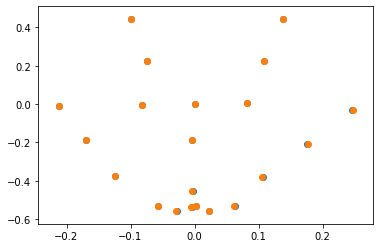

In [121]:
plt.scatter(front_view.reshape((21,2)).transpose()[0], front_view.reshape((21,2)).transpose()[1])
plt.scatter(front_view2.reshape((21,2)).transpose()[0], front_view2.reshape((21,2)).transpose()[1])